Processing batch 1/7


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saved batch 1/7 to /kaggle/working/processed_batches/batch_0
Processing batch 2/7


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saved batch 2/7 to /kaggle/working/processed_batches/batch_1
Processing batch 3/7


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saved batch 3/7 to /kaggle/working/processed_batches/batch_2
Processing batch 4/7


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saved batch 4/7 to /kaggle/working/processed_batches/batch_3
Processing batch 5/7


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saved batch 5/7 to /kaggle/working/processed_batches/batch_4
Processing batch 6/7


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saved batch 6/7 to /kaggle/working/processed_batches/batch_5
Processing batch 7/7


Map (num_proc=4):   0%|          | 0/180 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/180 [00:00<?, ? examples/s]

Saved batch 7/7 to /kaggle/working/processed_batches/batch_6


Saving the dataset (0/12 shards):   0%|          | 0/6180 [00:00<?, ? examples/s]

Final dataset saved successfully!


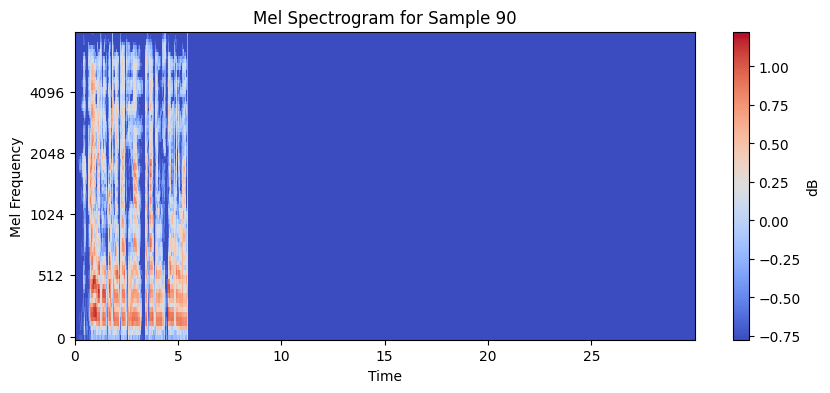

In [1]:
# Mount Kaggle input directory
import os
import pandas as pd
import numpy as np
import torch
import librosa.display
import matplotlib.pyplot as plt
from datasets import Dataset, Audio, load_from_disk, concatenate_datasets
from transformers import WhisperFeatureExtractor, WhisperTokenizer

# Define correct paths for Kaggle
INPUT_DIR = "/kaggle/input/speech-to-text-project"
AUDIO_DIR = os.path.join(INPUT_DIR, "converted_audio", "converted_audio")  # Fixed path
OUTPUT_DIR = "/kaggle/working"
SAVE_DIR = os.path.join(OUTPUT_DIR, "processed_batches")
FINAL_DATASET_PATH = os.path.join(OUTPUT_DIR, "final_dataset")

# Ensure output directories exist
os.makedirs(SAVE_DIR, exist_ok=True)

# Load mapping file (corrected path)
mapping = pd.read_csv(os.path.join(INPUT_DIR, "converted_mapping.csv"))

# Clean dataset (remove missing values & unwanted characters)
mapping = mapping.dropna()
mapping = mapping[mapping["text"].apply(lambda x: "(" not in x and ")" not in x)]

# Remove specific problematic files
exclude_files = ["427_Mazungumzo na mkutubi_1.wav", "430_Swa.story.002A_1.wav"]
mapping = mapping[~mapping["audio_file"].isin(exclude_files)]

# Create lists for audio and text sources
audio_sources = [os.path.join(AUDIO_DIR, file) for file in mapping["audio_file"]]
text_sources = mapping["text"].tolist()

# Load Whisper components
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-base")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-base", language="Swahili", task="transcribe")

# Set batch size
BATCH_SIZE = 1000  # Reduce if memory issues occur

# Function to preprocess dataset
def prepare_dataset(batch):
    audio = batch["audio"]

    # Compute log-Mel spectrogram features
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # Tokenize text
    batch["labels"] = tokenizer(batch["sentence"]).input_ids

    return batch

# Batch processing
num_batches = (len(audio_sources) + BATCH_SIZE - 1) // BATCH_SIZE

for i in range(num_batches):
    print(f"Processing batch {i+1}/{num_batches}")

    # Get batch slice
    start, end = i * BATCH_SIZE, min((i + 1) * BATCH_SIZE, len(audio_sources))

    # Create dataset for this batch
    batch_dataset = Dataset.from_dict({
        "audio": audio_sources[start:end],
        "sentence": text_sources[start:end]
    }).cast_column("audio", Audio(sampling_rate=16000))

    # Process and save batch
    processed_batch = batch_dataset.map(prepare_dataset, remove_columns=["audio", "sentence"], num_proc=4)
    batch_path = os.path.join(SAVE_DIR, f"batch_{i}")
    processed_batch.save_to_disk(batch_path)

    print(f"Saved batch {i+1}/{num_batches} to {batch_path}")

    # Free memory
    del batch_dataset, processed_batch
    torch.cuda.empty_cache()

# Load and concatenate processed batches
batch_dirs = sorted([os.path.join(SAVE_DIR, d) for d in os.listdir(SAVE_DIR)])
datasets = [load_from_disk(d) for d in batch_dirs]
final_dataset = concatenate_datasets(datasets)

# Save final dataset
final_dataset.save_to_disk(FINAL_DATASET_PATH)
print("Final dataset saved successfully!")

# Visualization of a sample's log-Mel spectrogram
dataset = load_from_disk(FINAL_DATASET_PATH)
sample_idx = 90  # Change index to view different samples
mel_spectrogram = np.array(dataset[sample_idx]["input_features"])

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, sr=16000, hop_length=160, x_axis="time", y_axis="mel")
plt.colorbar(label="dB")
plt.title(f"Mel Spectrogram for Sample {sample_idx}")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()

In [2]:
!pip install evaluate

In [3]:
!pip install jiwer

In [4]:
import jiwer

In [ ]:
import librosa
import os
import numpy as np
import pandas as pd
from datasets import Dataset, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments, Trainer
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import evaluate
import torch

# Load Whisper model and processor
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
processor = WhisperProcessor.from_pretrained("openai/whisper-base", language="Swahili", task="transcribe")

# Load the mapping CSV
mapping_path = "/kaggle/input/speech-to-text-project/converted_mapping.csv"
mapping = pd.read_csv(mapping_path)

# Clean dataset
mapping = mapping.dropna()
mapping = mapping[mapping["text"].apply(lambda x: "(" not in x and ")" not in x)]
exclude_files = ["427_Mazungumzo na mkutubi_1.wav", "430_Swa.story.002A_1.wav"]
mapping = mapping[~mapping["audio_file"].isin(exclude_files)]

# Dataset path for audio files
dataset_path = "/kaggle/input/speech-to-text-project/converted_audio/converted_audio"
audio_files = [os.path.join(dataset_path, filename) for filename in mapping["audio_file"]]

# Filter out non-existent files
valid_audio_files = [f for f in audio_files if os.path.exists(f)]
valid_indices = [i for i, f in enumerate(audio_files) if os.path.exists(f)]
valid_texts = mapping["text"].iloc[valid_indices].tolist()

if len(valid_audio_files) == 0:
    raise ValueError("No valid audio files found.")

# Create the dataset
dataset = Dataset.from_dict({
    "audio": valid_audio_files,
    "sentence": valid_texts
}).cast_column("audio", Audio(sampling_rate=16000))

# Split dataset
dataset_split = dataset.train_test_split(test_size=0.2)
train_dataset = dataset_split["train"]
val_dataset = dataset_split["test"]

# Preprocess function with error handling
def prepare_dataset(batch):
    try:
        audio = batch["audio"]
        if audio["sampling_rate"] != 16000:
            audio["array"] = librosa.resample(audio["array"], orig_sr=audio["sampling_rate"], target_sr=16000)
            audio["sampling_rate"] = 16000
        batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=16000).input_features[0]
        batch["labels"] = processor.tokenizer(batch["sentence"]).input_ids
    except Exception as e:
        print(f"Error processing sample: {e}")
        batch["input_features"] = None
        batch["labels"] = None
    return batch

# Apply preprocessing
train_dataset = train_dataset.map(prepare_dataset, remove_columns=["audio", "sentence"], num_proc=1)
train_dataset = train_dataset.filter(lambda x: x["input_features"] is not None and x["labels"] is not None)
val_dataset = val_dataset.map(prepare_dataset, remove_columns=["audio", "sentence"], num_proc=1)
val_dataset = val_dataset.filter(lambda x: x["input_features"] is not None and x["labels"] is not None)

# DataCollator
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        batch = self.processor.feature_extractor.pad(features, return_tensors="pt")
        label_features = [{"input_ids": feature["labels"]} for feature in features if "labels" in feature]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt", padding=True)
        labels = labels_batch["input_ids"]
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# Evaluation Metric
metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    pred_ids = np.where(pred_ids != -100, pred_ids, processor.tokenizer.pad_token_id)
    label_ids = np.where(label_ids != -100, label_ids, processor.tokenizer.pad_token_id)
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=1875,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=20,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    remove_unused_columns=False,
)

# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Map:   0%|          | 0/4944 [00:00<?, ? examples/s]

In [8]:
import os
import pandas as pd
import torch
from datasets import Dataset, load_from_disk, concatenate_datasets
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments, Trainer
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import evaluate
import numpy as np

# Paths (make sure they are correct and point to where you've stored your processed batches)
SAVE_DIR = "/kaggle/working/processed_batches"
FINAL_DATASET_PATH = "/kaggle/working/final_dataset"

# Load the processed dataset from disk (this is after batch processing in the first part)
final_dataset = load_from_disk(FINAL_DATASET_PATH)

# Check dataset sample to make sure it's loaded correctly
print(f"Loaded final dataset with {len(final_dataset)} samples.")

# Load Whisper components
processor = WhisperProcessor.from_pretrained("openai/whisper-base", language="Swahili", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

# Define DataCollator for padding and preparing batches during training
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, padding=True, return_tensors="pt")

        label_features = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, padding="max_length", max_length=448, return_tensors="pt")

        # Replace padding with -100 for loss computation
        labels = labels_batch["input_ids"].masked_fill(labels_batch["attention_mask"].ne(1), -100)
        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# Define the evaluation metric (WER)
metric = evaluate.load("wer")

# Function to compute metrics like WER
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    pred_ids = np.where(pred_ids != -100, pred_ids, processor.tokenizer.pad_token_id)
    label_ids = np.where(label_ids != -100, label_ids, processor.tokenizer.pad_token_id)
    
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

# Training setup with appropriate parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working",  # Adjust output directory as needed
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=1875,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=20,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    remove_unused_columns=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=final_dataset,
    eval_dataset=final_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

# Generate predictions on the validation set and print the first five predictions
predictions = trainer.predict(final_dataset)

# Get predictions and labels
pred_ids = predictions.predictions
label_ids = predictions.label_ids

# Decode the predictions and labels
pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

# Print first 5 predictions and corresponding labels
for i in range(5):
    print(f"Prediction {i+1}: {pred_str[i]}")
    print(f"Label {i+1}: {label_str[i]}")
    print()

# Compute and print WER
wer = 100 * metric.compute(predictions=pred_str, references=label_str)
print(f"Word Error Rate (WER): {wer}")


Loaded final dataset with 6180 samples.


KeyboardInterrupt: 

In [ ]:
import os
import torch
import evaluate
import numpy as np
import warnings
from datasets import Dataset, load_from_disk
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments, Trainer
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# Suppress warnings
warnings.filterwarnings("ignore")

# Paths (Ensure these are correct)
FINAL_DATASET_PATH = "/kaggle/working/final_dataset"

# Load the processed dataset from disk
final_dataset = load_from_disk(FINAL_DATASET_PATH)
print(f"Loaded final dataset with {len(final_dataset)} samples.")

# Split dataset into training (80%) and validation (20%) directly without pandas
split_dataset = final_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

# Load Whisper components
processor = WhisperProcessor.from_pretrained("openai/whisper-base", language="Swahili", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

# Disable cache in the model configuration
model.config.use_cache = False

# Define DataCollator for padding and preparing batches
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, padding=True, return_tensors="pt")

        label_features = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, padding="max_length", max_length=448, return_tensors="pt")

        # Replace padding with -100 for loss computation
        labels = labels_batch["input_ids"].masked_fill(labels_batch["attention_mask"].ne(1), -100)
        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# Define the evaluation metric (WER)
metric = evaluate.load("wer")

# Function to compute metrics like WER
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    pred_ids = np.where(pred_ids != -100, pred_ids, processor.tokenizer.pad_token_id)
    label_ids = np.where(label_ids != -100, label_ids, processor.tokenizer.pad_token_id)
    
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

# Training setup with appropriate parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working",
    per_device_train_batch_size=4,  # Low batch size to prevent memory issues
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=1875,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,  # Low eval batch size
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=20,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    remove_unused_columns=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

# Generate predictions on the validation set and print the first five predictions
predictions = trainer.predict(eval_dataset)

# Get predictions and labels
pred_ids = predictions.predictions
label_ids = predictions.label_ids

# Decode the predictions and labels
pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

# Print first 5 predictions and corresponding labels
for i in range(5):
    print(f"Prediction {i+1}: {pred_str[i]}")
    print(f"Label {i+1}: {label_str[i]}")
    print()

# Compute and print WER
wer = 100 * metric.compute(predictions=pred_str, references=label_str)
print(f"Word Error Rate (WER): {wer}")


Loaded final dataset with 6180 samples.


Step,Training Loss,Validation Loss
